## Combine CNNs and Naive Bayes predictions

In [1]:
import pandas as pd
import numpy as np
from sklearn.isotonic import IsotonicRegression
from sklearn.neighbors import NearestNeighbors
import networkx as nx
from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression

In [2]:
# dropout or full image 
USE_DROPOUT = False 

if not USE_DROPOUT:
    # CNN (calibrated) on combination splits
    CNN_TEST_PATH = "Project in DS/cnn_comb_test_calibrated_predictions.csv"
    CNN_VAL_PATH  = "Project in DS/cnn_comb_train_calibrated_predictions.csv"
    # BLR (no calibration) on combination splits
    NB_TEST_PATH  = "Project in DS/blr_full_comb_test_predictions.csv"
    NB_VAL_PATH   = "Project in DS/blr_full_comb_train_predictions.csv"
else:
    CNN_TEST_PATH = "Project in DS/cnn_dropout_comb_test_calibrated_predictions.csv"
    CNN_VAL_PATH  = "Project in DS/cnn_dropout_comb_train_calibrated_predictions.csv"
    NB_TEST_PATH  = "Project in DS/blr_dropout_comb_test_predictions.csv"
    NB_VAL_PATH   = "Project in DS/blr_dropout_comb_train_predictions.csv"


In [3]:
# Standardise dfs so merging will be easier 
def standardise_df(df, want_prefix, current_true_label_col=None):
    df = df.copy()
    # id column 
    if "id" not in df.columns:
        df.insert(0, "id", np.arange(len(df)))

    # true_label column
    if "true_label" not in df.columns:
        cand = current_true_label_col if current_true_label_col else ("label" if "label" in df.columns else None)
        if cand is not None:
            df = df.rename(columns={cand: "true_label"})
        else:
            pass

    # find prob columns 
    prob_cols = [c for c in df.columns if "_class_" in c]
    def _cls_idx(c):
        try:
            return int(c.split("_")[-1])
        except:
            return 0
    prob_cols = sorted(prob_cols, key=_cls_idx)

    # rename to the expected prefix 
    rename_map = {c: f"{want_prefix}_class_{_cls_idx(c)}" for c in prob_cols}
    df = df.rename(columns=rename_map)

    return df

1. Accurate Probability Calibration for Multiple Classifiers by Leon Wenliang Zhong and James T. Kwok

In their paper they use soft voting (averaging the probabilities) to get an ensemble starting point for each class. Then they fit an isotonic regression to make the combined probability well-calibrated and finally optimise using alternating direction method of multipliers (ADMM). 

I will try to replicate their method and see if it improves the accuracy. (exact steps on the paper page 1942)

### Merging CNN and BLR for test

In [4]:
# TEST DATASET 
# Calibrated preds of cnn 
cnn_preds_test = pd.read_csv(CNN_TEST_PATH)
# standardize CNN columns to cnn_class_k + ensure id/true_label exist
cnn_preds_test = standardise_df(cnn_preds_test, want_prefix="cnn")

cnn_preds_test.head()

# The predictions for the Naive Bayes classifier are currently not calibrated - I use it as is just to test my part. 
# Once we have the calibrated preds we can change them.
nb_preds_test = pd.read_csv(NB_TEST_PATH)

# BLR files usually have 'label' and no 'id'
nb_preds_test = standardise_df(nb_preds_test, want_prefix="nb")
nb_preds_test.head()

# Merge the two datasets
cnn_nb_combined_test = cnn_preds_test.merge(nb_preds_test, on="id")

# Get the probs for the CNN and NB
cnn_probs_test = cnn_nb_combined_test[[f"cnn_class_{i}" for i in range(10)]].values
nb_probs_test  = cnn_nb_combined_test[[f"nb_class_{i}"  for i in range(10)]].values

# Sanity checks 
# Check if probs sum to 1 for the CNN and NB
cnn_sum = cnn_nb_combined_test[[f"cnn_class_{i}" for i in range(10)]].sum(axis=1)
print(cnn_sum)

nb_sum = cnn_nb_combined_test[[f"nb_class_{i}" for i in range(10)]].sum(axis=1)
print(nb_sum)

# Calculate the average prob between CNN and NB 
avg_probs_test = 0.5 * cnn_probs_test + 0.5 * nb_probs_test

# Get the highest (final prediction)
avg_preds_test = np.argmax(avg_probs_test, axis=1)
# both frames have 'true_label' 
y_true_test = cnn_nb_combined_test["true_label_y"].values

# Get the accuracy 
accuracy = (avg_preds_test == y_true_test).mean() * 100
print(f"Accuracy Test (average): {accuracy}%")


0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
4795    1.0
4796    1.0
4797    1.0
4798    1.0
4799    1.0
Length: 4800, dtype: float64
0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
4795    1.0
4796    1.0
4797    1.0
4798    1.0
4799    1.0
Length: 4800, dtype: float64
Accuracy Test (average): 89.35416666666667%


### Merging CNN and BLR for Val 

In [5]:
# VALIDATION DATASET
# Validation preds of CNN and NB
cnn_preds_val = pd.read_csv(CNN_VAL_PATH)
cnn_preds_val = standardise_df(cnn_preds_val, want_prefix="cnn")
cnn_preds_val.head()

nb_preds_val = pd.read_csv(NB_VAL_PATH)
nb_preds_val = standardise_df(nb_preds_val, want_prefix="nb")
nb_preds_val.head()

# Merge the two datasets 
cnn_nb_combined_val = cnn_preds_val.merge(nb_preds_val, on="id")

# Get the probs for the CNN and NB
cnn_probs_val = cnn_nb_combined_val[[f"cnn_class_{i}" for i in range(10)]].values
nb_probs_val  = cnn_nb_combined_val[[f"nb_class_{i}"  for i in range(10)]].values

y_true_val = cnn_nb_combined_val["true_label_y"].values

# Repeat for validation
avg_probs_val = 0.5 * cnn_probs_val + 0.5 * nb_probs_val
avg_preds_val = np.argmax(avg_probs_val, axis=1)

accuracy_val = (avg_preds_val == y_true_val).mean() * 100
print(f"Accuracy Val (average): {accuracy_val}%")


Accuracy Val (average): 89.04166666666666%


### Calculating the Negative Log-Likelihood and Expected Calibration Error

In [6]:
from sklearn.metrics import log_loss

# Calculate NLL and ECE for validation and testing set 
nll_val = log_loss(y_true_val, avg_probs_val, labels=np.arange(10))
print(f"NLL Val (average): {nll_val}")

nll_test = log_loss(y_true_test, avg_probs_test, labels=np.arange(10))
print(f"NLL Test (average): {nll_test}")


def ece_score(probs, labels, n_bins=15):
    confidences = probs.max(axis=1)
    predictions = probs.argmax(axis=1)
    accuracies = (predictions == labels)

    bins = np.linspace(0, 1, n_bins + 1)
    ece = 0.0
    for i in range(n_bins):
        mask = (confidences > bins[i]) & (confidences <= bins[i+1])
        if mask.any():
            bin_acc = accuracies[mask].mean()
            bin_conf = confidences[mask].mean()
            ece += np.abs(bin_acc - bin_conf) * mask.mean()
    return ece

ece_val = ece_score(avg_probs_val, y_true_val)
print(f"ECE Val (average): {ece_val}")

ece_test = ece_score(avg_probs_test, y_true_test)
print(f"ECE Test (average): {ece_test}")


NLL Val (average): 0.4818627455555805
NLL Test (average): 0.4687900580408005
ECE Val (average): 0.17960157582764352
ECE Test (average): 0.18347657851176266


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2956: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2956: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


In [7]:
# All results for simple average (50/50)
print(f"Accuracy Test (average): {accuracy}%")
print(f"Accuracy Val (average): {accuracy_val}%")
print()
print(f"NLL Val (average): {nll_val}")
print(f"NLL Test (average): {nll_test}")
print()
print(f"ECE Val (average): {ece_val}")
print(f"ECE Test (average): {ece_test}")
print()
# Obersvation the ECE is vert low but around 0.05 would be calibrated

Accuracy Test (average): 89.35416666666667%
Accuracy Val (average): 89.04166666666666%

NLL Val (average): 0.4818627455555805
NLL Test (average): 0.4687900580408005

ECE Val (average): 0.17960157582764352
ECE Test (average): 0.18347657851176266



### Validation-weighted average
The model that performs better (higher AUC) on validation should get more influence in the final ensemble

In [8]:
# Weighted Average using AUC (macro one-vs-rest) - Eq 7 from the paper 
from sklearn.metrics import roc_auc_score

auc_cnn = roc_auc_score(y_true_val, cnn_probs_val, multi_class="ovr", average='macro')
auc_nb  = roc_auc_score(y_true_val, nb_probs_val,  multi_class="ovr", average='macro')

print(f"AUC CNN Val: {auc_cnn}  and  AUC NB Val: {auc_nb}")

# Calculate eta (Eq 7)
# μ is the average of (1 − AUCc) over the C classifiers
# (fixed the parenthesis bug so it's truly an average)
m = ((1 - auc_cnn) + (1 - auc_nb)) / 2.0

# η_c ∝ exp( - (1 - AUC_c) / (2 μ) )  → then normalize to sum to 1
eta_cnn_unnorm = np.exp(-(1 - auc_cnn) / (2.0 * m))
eta_nb_unnorm  = np.exp(-(1 - auc_nb)  / (2.0 * m))

# Z normalizes {ηc}Cc=1 to sum to 1
Z = eta_cnn_unnorm + eta_nb_unnorm

eta_cnn = eta_cnn_unnorm / Z
eta_nb  = eta_nb_unnorm  / Z

print(f"Eta (weights) for CNN: {eta_cnn} and NB: {eta_nb}")

# Use the weights to calculate a new wgt avg and pick the highest 
wgt_avg_probs_val  = eta_cnn * cnn_probs_val + eta_nb * nb_probs_val
wgt_avg_preds_val  = np.argmax(wgt_avg_probs_val, axis=1)

wgt_avg_probs_test = eta_cnn * cnn_probs_test + eta_nb * nb_probs_test
wgt_avg_preds_test = np.argmax(wgt_avg_probs_test, axis=1)

# Calculate the metrics for wgt_val
acc_wgt_avg_val  = (wgt_avg_preds_val  == y_true_val).mean() * 100
nll_wgt_avg_val  = log_loss(y_true_val,  wgt_avg_probs_val,  labels=np.arange(10))
ece_wgt_avg_val  = ece_score(wgt_avg_probs_val,  y_true_val)

# Calculate the metrics for wgt_test
acc_wgt_avg_test = (wgt_avg_preds_test == y_true_test).mean() * 100
nll_wgt_avg_test = log_loss(y_true_test, wgt_avg_probs_test, labels=np.arange(10))
ece_wgt_avg_test = ece_score(wgt_avg_probs_test, y_true_test)



AUC CNN Val: 0.9903645917848202  and  AUC NB Val: 0.9439482804073871
Eta (weights) for CNN: 0.669655467039116 and NB: 0.33034453296088384


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2956: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2956: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


In [9]:
# All results for weighted average
print(f"Accuracy Test (Weighted Average): {acc_wgt_avg_test}%")
print(f"Accuracy Val (Weighted Average): {acc_wgt_avg_val}%")
print()
print(f"NLL Val (Weighted Average): {nll_wgt_avg_val}")
print(f"NLL Test (Weighted Average): {nll_wgt_avg_test}")
print()
print(f"ECE Val (Weighted Average): {ece_wgt_avg_val}")
print(f"ECE Test (Weighted Average): {ece_wgt_avg_test}")
print()


Accuracy Test (Weighted Average): 89.4375%
Accuracy Val (Weighted Average): 89.11458333333333%

NLL Val (Weighted Average): 0.4110672363736175
NLL Test (Weighted Average): 0.3974945196568485

ECE Val (Weighted Average): 0.12101190416971054
ECE Test (Weighted Average): 0.12511775757806326



Validation AUCs -> CNN: 0.990, BLR: 0.944


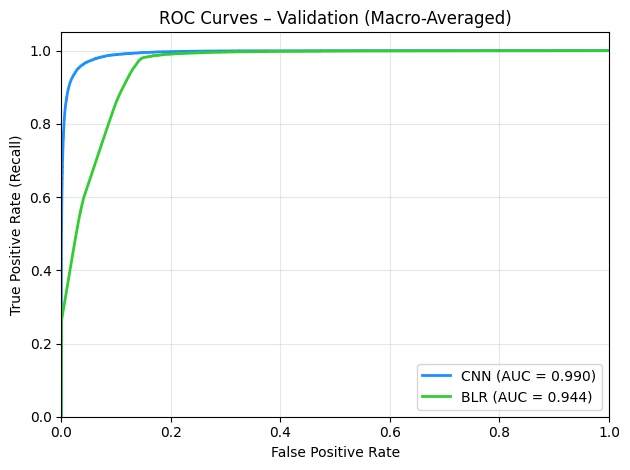

In [10]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# compute a macro-average ROC by flattening the true/score arrays
# Macro average : computing the area under the ROC curve (AUC) separately for each class in a multi-class s, and then we take mean of these per-class AUC values.
# Look here for more information:  https://www.geeksforgeeks.org/machine-learning/macro-average-vs-weighted-average/

auc_cnn = roc_auc_score(y_true_val, cnn_probs_val, multi_class="ovr", average="macro")
auc_blr = roc_auc_score(y_true_val, nb_probs_val,  multi_class="ovr", average="macro")

print(f"Validation AUCs -> CNN: {auc_cnn:.3f}, BLR: {auc_blr:.3f}")

# binary labels 
n_classes = cnn_probs_val.shape[1]
y_true_bin = label_binarize(y_true_val, classes=np.arange(n_classes))


#macro-averaged ROC for CNN
fpr_cnn, tpr_cnn, _ = roc_curve(y_true_bin.ravel(), cnn_probs_val.ravel())
# macro-averaged ROC for BLR
fpr_blr, tpr_blr, _ = roc_curve(y_true_bin.ravel(), nb_probs_val.ravel())

# AUC 
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)
roc_auc_blr = auc(fpr_blr, tpr_blr)

plt.figure()
plt.plot(fpr_cnn, tpr_cnn, color='dodgerblue', lw=2,
         label=f'CNN (AUC = {auc_cnn:.3f})')
plt.plot(fpr_blr, tpr_blr, color='limegreen', lw=2,
         label=f'BLR (AUC = {auc_blr:.3f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curves – Validation (Macro-Averaged)')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [11]:
# Multi-Isotonic Calibration Model (MIC)

#  MIC constraints (soft voting) Eq 2 (paper)

# DAG Eq 3 (paper) ?? tree ordering?

### Combine CNN and Bayesian Logistic Regression into "one" smarter model.

2. Applying probability calibration to ensemble methods to predict 2-year mortality in patients with DLBCL
Shuanglong Fan, Zhiqiang Zhao, Hongmei Yu, Lei Wang, Chuchu Zheng, Xueqian Huang,
Zhenhuan Yang, Meng Xing, Qing Lu and Yanhong Luo

The third part is the combination of the base models. We used three methods (simple averaging, weighted averaging, and stacking) to combine the above 5 base models. Stacking or stacked generalization, which takes the outputs of the base models as its inputs, uses another machine learning algorithm (also called a meta-learner)

In [12]:
# Stacking meta-learner
def stacking_multinomial_from_frames(cnn_val_df, nb_val_df, cnn_test_df, nb_test_df):

    # Merge the two prediction files
    val_merged = cnn_val_df.merge(nb_val_df, on="id", suffixes=("_cnn", "_nb"))
    test_merged = cnn_test_df.merge(nb_test_df, on="id", suffixes=("_cnn", "_nb"))

    n_classes = 10  

    # Get the probability columns per class
    cnn_cols = [f"cnn_class_{i}" for i in range(n_classes)]
    nb_cols  = [f"nb_class_{i}"  for i in range(n_classes)]

    # Get the probability values per class
    cnn_val = val_merged[cnn_cols].values
    nb_val  = val_merged[nb_cols].values
    y_val   = val_merged["true_label_cnn"].values  

    cnn_test = test_merged[cnn_cols].values
    nb_test  = test_merged[nb_cols].values
    y_test   = test_merged["true_label_cnn"].values

    # Create the hstack table that will be needed for the regression 
    x_val  = np.hstack([cnn_val, nb_val])
    x_test = np.hstack([cnn_test, nb_test])

    # Train multinomial logistic regression
    stacker = LogisticRegression(
        multi_class="multinomial",
        solver="lbfgs",
        max_iter=1000
    )
    stacker.fit(x_val, y_val)

    # Get the predicted & calibrated probs 
    stacked_val  = stacker.predict_proba(x_val)
    stacked_test = stacker.predict_proba(x_test)

    return stacked_val, stacked_test, y_val, y_test, stacker, x_val, x_test

# Perform stacking 
stack_val, stack_test, y_val, y_test, stack_model, x_val, x_test = stacking_multinomial_from_frames(
    cnn_preds_val, nb_preds_val,
    cnn_preds_test, nb_preds_test)

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [13]:
# Calculate metrics for validation 
acc_stack_val = (np.argmax(stack_val, axis=1) == y_val).mean() * 100
nll_stack_val = log_loss(y_val, stack_val, labels=np.arange(stack_val.shape[1])) # cross-entropy loss
ece_stack_val = ece_score(stack_val, y_val)

# Calculate metrics for testing  
acc_stack_test = (np.argmax(stack_test, axis=1) == y_test).mean() * 100
nll_stack_test = log_loss(y_test, stack_test, labels=np.arange(stack_test.shape[1])) #cross-entropy loss
ece_stack_test = ece_score(stack_test, y_test)

# All results for calibration using stacking (meta-learner)
print(f"Accuracy Test (Stacking): {acc_stack_test}%")
print(f"Accuracy Val (Stacking): {acc_stack_val}%")
print()
print(f"NLL Val (Stacking): {nll_stack_val}")
print(f"NLL Test (Stacking): {nll_stack_test}")
print()
print(f"ECE Val (Stacking): {ece_stack_val}")
print(f"ECE Test (Stacking): {ece_stack_test}")
print()

Accuracy Test (Stacking): 89.79166666666667%
Accuracy Val (Stacking): 89.51041666666667%

NLL Val (Stacking): 0.3183172927676654
NLL Test (Stacking): 0.3044957661715378

ECE Val (Stacking): 0.009859285226806533
ECE Test (Stacking): 0.018243943249223002



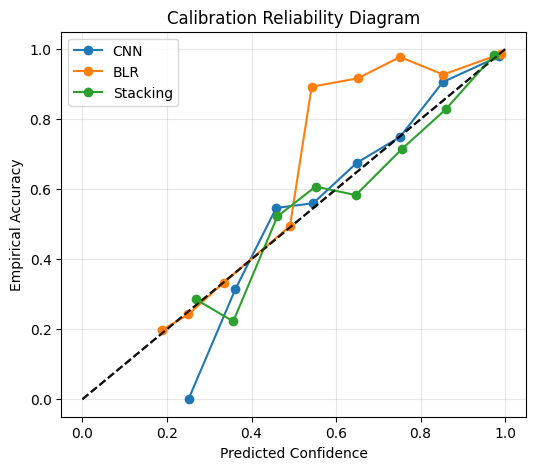

In [14]:
from sklearn.calibration import calibration_curve

# Calibration Reliability Diagram to compare how well-calibrated the CNN, BLR, and Stacking (combined) models are.
def plot_calibration(probs, y_true, name):
    confidences = np.max(probs, axis=1)
    preds = np.argmax(probs, axis=1)
    accs, bins = calibration_curve((preds == y_true), confidences, n_bins=10, strategy='uniform')
    
    plt.plot(bins, accs, marker='o', label=name)
    plt.plot([0,1], [0,1], 'k--', alpha=0.6)
    plt.xlabel('Predicted Confidence') # how sure the model says it is.
    plt.ylabel('Empirical Accuracy') # how often the model is right given its confidence.
    plt.title('Calibration Reliability Diagram')
    plt.legend()
    plt.grid(alpha=0.3)

plt.figure(figsize=(6,5))
plot_calibration(cnn_probs_test, y_true_test, 'CNN')
plot_calibration(nb_probs_test, y_true_test, 'BLR')
plot_calibration(stack_test, y_test, 'Stacking')
plt.show()


Get coeffients of the meta learner (multinomial logistic regression)

In [15]:
# Rebuild meta-features outside the function 
n_classes = 10

# Merge CNN & NB validation preds
val_merged = cnn_preds_val.merge(nb_preds_val, on="id", suffixes=("_cnn", "_nb"))
test_merged = cnn_preds_test.merge(nb_preds_test, on="id", suffixes=("_cnn", "_nb"))

# Extract probability matrices
cnn_val = val_merged[[f"cnn_class_{i}" for i in range(n_classes)]].values
nb_val  = val_merged[[f"nb_class_{i}"  for i in range(n_classes)]].values
cnn_test = test_merged[[f"cnn_class_{i}" for i in range(n_classes)]].values
nb_test  = test_merged[[f"nb_class_{i}"  for i in range(n_classes)]].values

# True labels
y_val  = val_merged["true_label_cnn"].values
y_test = test_merged["true_label_cnn"].values

# Combine 
x_val  = np.hstack([cnn_val, nb_val])
x_test = np.hstack([cnn_test, nb_test])


In [16]:
stack_model.fit(x_val, y_val)
# naming each class
feature_names = [f"cnn_class_{i}" for i in range(n_classes)] + [f"nb_class_{i}" for i in range(n_classes)]

coef_df = pd.DataFrame(stack_model.coef_, columns=feature_names)
coef_df.index = [f"class_{i}" for i in range(n_classes)]

print("\n=== Meta-learner Coefficients (per class) ===")
print(coef_df.shape)
print(coef_df.round(4))



c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



=== Meta-learner Coefficients (per class) ===
(10, 20)
         cnn_class_0  cnn_class_1  cnn_class_2  cnn_class_3  cnn_class_4  \
class_0       4.1251      -1.1506       0.5634       0.0404      -1.2778   
class_1      -1.3129       5.1700      -0.9208       0.3734      -0.4977   
class_2       0.6188      -1.3470       4.4534      -1.1091       0.5421   
class_3      -0.1255      -0.0054      -0.3862       3.9181       0.5120   
class_4      -1.2108      -0.2570       0.6280       0.0314       4.5183   
class_5      -1.1495      -0.5906      -0.9015      -0.9841      -1.0339   
class_6       1.4946      -0.9054       0.2910      -0.2563      -0.3328   
class_7      -1.1157      -0.5256      -1.1468      -1.0411      -0.8657   
class_8      -0.1941       0.0725      -1.2748       0.1871      -0.6629   
class_9      -1.1300      -0.4610      -1.3058      -1.1599      -0.9016   

         cnn_class_5  cnn_class_6  cnn_class_7  cnn_class_8  cnn_class_9  \
class_0      -0.7696       1.22

In [17]:
# Average coefficient magnitude per model (absolute - ignore the signs)
# absolute value removes cancellation, capturing the magnitude of influence
cnn_importance = coef_df[[c for c in coef_df.columns if "cnn" in c]].abs().mean().mean()
nb_importance  = coef_df[[c for c in coef_df.columns if "nb"  in c]].abs().mean().mean()

print(f"\nAverage |Coef| magnitude:")
print(f"  CNN features:  {cnn_importance:.4f}")
print(f"  NB features:   {nb_importance:.4f}")

# observatrion: The meta-learner relies more heavily on CNN’s outputs


Average |Coef| magnitude:
  CNN features:  1.1503
  NB features:   0.9907


In [18]:
# Average coefficient magnitude per model (absolute - ignore the signs)
cnn_per_class = coef_df[[f"cnn_class_{i}" for i in range(n_classes)]].abs().mean(axis=1)
nb_per_class  = coef_df[[f"nb_class_{i}"  for i in range(n_classes)]].abs().mean(axis=1)

# Compare them
pref_df = pd.DataFrame({
    "Class": coef_df.index,
    "CNN |Coef| Mean": cnn_per_class.round(3),
    "NB |Coef| Mean": nb_per_class.round(3),
    "Preferred Model": [
        "CNN" if cnn_per_class[i] > nb_per_class[i] else "NB"
        for i in range(len(coef_df))]})

print(pref_df.to_markdown(index=False))


| Class   |   CNN |Coef| Mean |   NB |Coef| Mean | Preferred Model   |
|:--------|------------------:|-----------------:|:------------------|
| class_0 |             1.186 |            1.23  | NB                |
| class_1 |             1.145 |            0.95  | CNN               |
| class_2 |             1.192 |            0.848 | CNN               |
| class_3 |             0.865 |            0.886 | NB                |
| class_4 |             1.098 |            1.086 | CNN               |
| class_5 |             1.425 |            0.936 | CNN               |
| class_6 |             1.112 |            0.897 | CNN               |
| class_7 |             1.191 |            1.129 | CNN               |
| class_8 |             0.976 |            0.9   | CNN               |
| class_9 |             1.312 |            1.045 | CNN               |


C:\Users\saber\AppData\Local\Temp\ipykernel_11240\850195543.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "CNN" if cnn_per_class[i] > nb_per_class[i] else "NB"


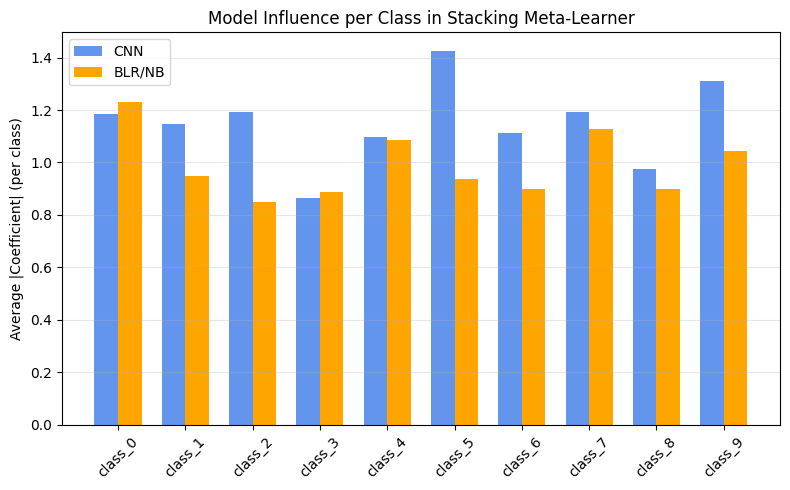

In [19]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(pref_df["Class"]))  # positions for classes
width = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - width/2, pref_df["CNN |Coef| Mean"], width, label="CNN", color="cornflowerblue")
plt.bar(x + width/2, pref_df["NB |Coef| Mean"],  width, label="BLR/NB", color="orange")

plt.xticks(x, pref_df["Class"], rotation=45)
plt.ylabel("Average |Coefficient| (per class)")
plt.title("Model Influence per Class in Stacking Meta-Learner")
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


# SUMMARY FULL IMAGE

### Full Images – Combination Results

| Metric Direction | **↑ Accuracy** | **↓ NLL** | **↓ ECE** |
|:-------------------|:--------------:|:----------:|:----------:|
| **Individual Models (for reference)** | | | |
| Bayesian (BLR) | 54.63% | 0.8906 | 0.0197 |
| CNN (Calibrated)| 89.19% | 0.3113 | 0.0181 |
| **Combination Methods** | | | |
| Simple Average (50/50) | Val = 89.04%, Test = 89.35% | Val = 0.4819, Test = 0.4688 | Val = 0.1796, Test = 0.1835 |
| Weighted Average (AUC-based) | Val = 89.11%, Test = 89.44% | Val = 0.4111, Test = 0.3975 | Val = 0.1210, Test = 0.1251 |
| Stacking (Meta-Model) | Val = 89.51%, Test = 89.79% | Val = 0.3183, Test = 0.3045 | Val = 0.0099, Test = 0.0182 |

Observations:
- CNN performs strongly on its own (~89% accuracy), while the Bayesian model is much weaker (~55%).  
- All combination methods outperform individual models.  
- The Stacking meta-model achieves the best calibration (lowest ECE) and lowest NLL, with a good in accuracy.  
- This shows that the meta-learner effectively learns when to trust CNN vs Bayes.




### Meta-Learner Coefficient Summary — Full Images
| Metric | CNN Features | NB Features |
|:-------|:-------------:|:------------:|
| **Average \|Coef\| Magnitude** | **1.1503** | **0.9907** |

| Class | CNN \|Coef\ Mean | NB \|Coef\ Mean | Preferred Model |
|:------|------------------:|-----------------:|:----------------|
| class_0 | 1.186 | 1.230 | NB |
| class_1 | 1.145 | 0.950 | CNN |
| class_2 | 1.192 | 0.848 | CNN |
| class_3 | 0.865 | 0.886 | NB |
| class_4 | 1.098 | 1.086 | CNN |
| class_5 | 1.425 | 0.936 | CNN |
| class_6 | 1.112 | 0.897 | CNN |
| class_7 | 1.191 | 1.129 | CNN |
| class_8 | 0.976 | 0.900 | CNN |
| class_9 | 1.312 | 1.045 | CNN |

Mostly relies on the CNN, with consistently higher coefficients across most classes.
The Naive Bayes model contributes to two classes (class 0 and 3), but overall, the CNN dominates the combination strategy.

# SUMMARY DROPOUT IMAGES

### Dropout Images – Combination Results


| Metric Direction | **↑ Accuracy** | **↓ NLL** | **↓ ECE** |
|:-----------------|:--------------:|:----------:|:----------:|
| **Individual Models (for reference)** | | | |
| Bayesian (BLR) | 57.37% | 0.8715 | 0.0290 |
| CNN (Calibrated) | 89.19% | 0.3113 | 0.0181 |
| **Combination Methods** | | | |
| Simple Average (50/50) | Val = 78.19%, Test = 77.38% | Val = 0.5984, Test = 0.6036 | Val = 0.0927, Test = 0.0875 |
| Weighted Average (AUC-based) | Val = 78.01%, Test = 77.13% | Val = 0.5842, Test = 0.5895 | Val = 0.0708, Test = 0.0745 |
| Stacking (Meta-Model) | Val = 82.80%, Test = 82.29% | Val = 0.4587, Test = 0.4721 | Val = 0.0125, Test = 0.0123 |

Observations: 
- With degraded images, both individual models lose accuracy as expected, however CNN remains stronger.
- The Stacking meta-model again provides the best balance. Even with degraded images is well colibrated (ECE ~0.012).

### Meta-Learner Coefficient Summary — Degraded Images

| Metric | CNN Features | NB Features |
|:-------|:-------------:|:------------:|
| **Average \|Coef\| Magnitude** | **1.1896** | **1.1933** |


| Class | CNN \|Coef\ Mean | NB \|Coef\ Mean | Preferred Model |
|:------|------------------:|-----------------:|:----------------|
| class_0 | 1.206 | 1.289 | NB |
| class_1 | 0.871 | 1.231 | NB |
| class_2 | 1.181 | 0.970 | CNN |
| class_3 | 1.325 | 1.084 | CNN |
| class_4 | 1.217 | 1.951 | NB |
| class_5 | 1.381 | 1.070 | CNN |
| class_6 | 1.230 | 1.182 | CNN |
| class_7 | 1.432 | 1.193 | CNN |
| class_8 | 0.986 | 0.973 | CNN |
| class_9 | 1.066 | 0.989 | CNN |

For degraded images, the meta-learner is more balanced, giving nearly equal overall weight to CNN and Naive Bayes features.
It trusts more the Bayes model for classes (0, 1, and 4).

# Train several meta learners 
Important to mention that i combined the predictions of CNN and BLR for both full and drop out images and all these 4 columns for 10 classes will be the 40 features that will be used to train a new meta learner. 

- A static one (Logistic Regression) that will learn the weights for each model and whether is a full or drop out images and apply it to make new predicions

- A dynamic one (Random Forest and Gradient Boosting) that will learn to adjust the weights based on the patterns observed in the input features

Since it combines the predictions from both full and degraded images it can be considered as a kind of data augmentation where the meta-model sees a wider range of inputs and learns to handle uncertainty

In [20]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import log_loss

In [21]:
# Load the csv files containing the predictions
def load_preds(path, prefix):
    df = pd.read_csv(path).copy()
    if "true_label" not in df.columns and "label" in df.columns:
        df = df.rename(columns={"label": "true_label"})
    prob_cols = [c for c in df.columns if "_class_" in c]
    for c in prob_cols:
        idx = c.split("_")[-1]
        df = df.rename(columns={c: f"{prefix}_class_{idx}"})
    if "id" not in df.columns:
        df.insert(0, "id", np.arange(len(df)))
    return df

cnn_full_train = load_preds("Project in DS/cnn_comb_train_calibrated_predictions.csv", "cnn_full")
cnn_full_test  = load_preds("Project in DS/cnn_comb_test_calibrated_predictions.csv", "cnn_full")

cnn_drop_train = load_preds("Project in DS/cnn_dropout_comb_train_calibrated_predictions.csv", "cnn_drop")
cnn_drop_test  = load_preds("Project in DS/cnn_dropout_comb_test_calibrated_predictions.csv", "cnn_drop")

blr_full_train = load_preds("Project in DS/blr_full_comb_train_predictions.csv", "blr_full")
blr_full_test  = load_preds("Project in DS/blr_full_comb_test_predictions.csv", "blr_full")

blr_drop_train = load_preds("Project in DS/blr_dropout_comb_train_predictions.csv", "blr_drop")
blr_drop_test  = load_preds("Project in DS/blr_dropout_comb_test_predictions.csv", "blr_drop")

### Combing the data to one meta-training and meta-testing dataset

In [22]:
# Clean up duplicate true_label columns before merging otherwise python complaints  
def drop_extra_labels(df):
    cols = [c for c in df.columns if "true_label" in c]
    if len(cols) > 1:
        df = df.drop(columns=cols[1:])
    return df

cnn_full_train = drop_extra_labels(cnn_full_train)
cnn_drop_train = drop_extra_labels(cnn_drop_train)
blr_full_train = drop_extra_labels(blr_full_train)
blr_drop_train = drop_extra_labels(blr_drop_train)

cnn_full_test = drop_extra_labels(cnn_full_test)
cnn_drop_test = drop_extra_labels(cnn_drop_test)
blr_full_test = drop_extra_labels(blr_full_test)
blr_drop_test = drop_extra_labels(blr_drop_test)

# Merge datasets on id
train_df = (
    cnn_full_train
    .merge(cnn_drop_train, on="id", suffixes=("", "_dup1"))
    .merge(blr_full_train, on="id", suffixes=("", "_dup2"))
    .merge(blr_drop_train, on="id", suffixes=("", "_dup3")))

test_df = (
    cnn_full_test
    .merge(cnn_drop_test, on="id", suffixes=("", "_dup1"))
    .merge(blr_full_test, on="id", suffixes=("", "_dup2"))
    .merge(blr_drop_test, on="id", suffixes=("", "_dup3")))

print("Train:", train_df.shape, "Test:", test_df.shape)


Train: (19200, 45) Test: (4800, 45)


In [23]:
# Split dependent and independent vars 
feature_cols = [c for c in train_df.columns if "_class_" in c]
X_train = train_df[feature_cols].values
y_train = train_df["true_label"].values 
X_test  = test_df[feature_cols].values
y_test  = test_df["true_label"].values

print("Features:", len(feature_cols))

# Meta-learners model used 
models = {
    "LogReg": LogisticRegression(max_iter=1000, multi_class="multinomial"),
    "RF": RandomForestClassifier(n_estimators=200, max_depth=None, random_state=0),
    "GBM": GradientBoostingClassifier(n_estimators=300, learning_rate=0.05, max_depth=3, random_state=0)}

# Fit, test each of them and evaluate them 
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    probs_val = model.predict_proba(X_train)
    probs_test = model.predict_proba(X_test)

    acc_val = (np.argmax(probs_val, 1) == y_train).mean() * 100
    acc_test = (np.argmax(probs_test, 1) == y_test).mean() * 100
    nll_val = log_loss(y_train, probs_val, labels=np.arange(probs_val.shape[1]))
    nll_test = log_loss(y_test, probs_test, labels=np.arange(probs_test.shape[1]))
    ece_val = ece_score(probs_val, y_train)
    ece_test = ece_score(probs_test, y_test)

    results.append({
        "Model": name,
        "Accuracy (Val)": acc_val,
        "Accuracy (Test)": acc_test,
        "NLL (Val)": nll_val,
        "NLL (Test)": nll_test,
        "ECE (Val)": ece_val,
        "ECE (Test)": ece_test})


Features: 40


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [24]:
# Summary 
results_df = pd.DataFrame(results)
display(results_df.style.format({
    "Accuracy (Val)": "{:.2f}%",
    "Accuracy (Test)": "{:.2f}%",
    "NLL (Val)": "{:.4f}",
    "NLL (Test)": "{:.4f}",
    "ECE (Val)": "{:.4f}",
    "ECE (Test)": "{:.4f}"}))


,Model,Accuracy (Val),Accuracy (Test),NLL (Val),NLL (Test),ECE (Val),ECE (Test)
0,LogReg,89.80%,90.12%,0.2965,0.2891,0.0084,0.0064
1,RF,100.00%,90.12%,0.0670,0.3182,0.0592,0.0221
2,GBM,95.06%,89.65%,0.1510,0.2920,0.0321,0.0183


 Check the coefficients or importance given to each model (CNN or BLR) and image type (full or degraded)

In [25]:
# Extract absolute coefficients
coef = np.abs(stack_model.coef_)  
avg_importance = coef.mean(axis=0)

# number of features
n_features = avg_importance.shape[0]
feature_names_used = feature_cols[:n_features] 

importance_df = pd.DataFrame({
    'feature': feature_names_used,
    'importance': avg_importance})

# Group features by model and image source
importance_df['source'] = importance_df['feature'].apply(
    lambda f: (
        'CNN (Full)' if 'cnn_full' in f else
        'CNN (Drop)' if 'cnn_drop' in f else
        'BLR (Full)' if 'blr_full' in f else
        'BLR (Drop)' if 'blr_drop' in f else 'Other'))

# Aggregate importance
grouped = importance_df.groupby('source')['importance'].mean().sort_values(ascending=False)
print("Logistic Regression Feature Importance")
print(grouped)


Logistic Regression Feature Importance
source
CNN (Full)    1.150284
CNN (Drop)    0.990734
Name: importance, dtype: float64


In [26]:
# Fit each meta-learner outside the function
rf_model = RandomForestClassifier(n_estimators=200, max_depth=None, random_state=0)
rf_model.fit(X_train, y_train)

gbm_model = GradientBoostingClassifier(n_estimators=300, learning_rate=0.05, max_depth=3, random_state=0)
gbm_model.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.05, n_estimators=300, random_state=0)

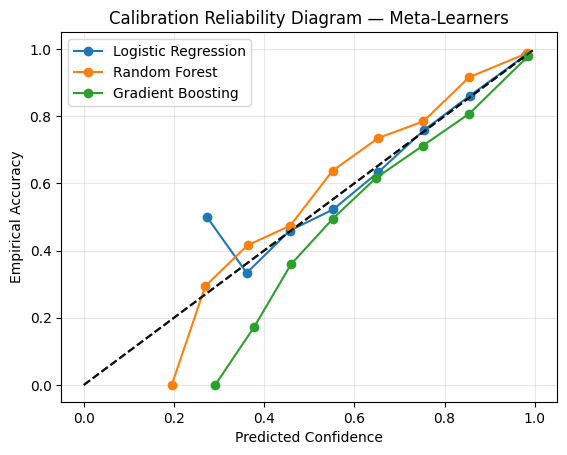

In [27]:
# Plot calibration for meta-learners (LogReg, RF, GBM)
import matplotlib.pyplot as plt
plt.figure()

probs_logreg = models["LogReg"].predict_proba(X_test)
plot_calibration(probs_logreg, y_test, 'Logistic Regression')

probs_rf = models["RF"].predict_proba(X_test)
plot_calibration(probs_rf, y_test, 'Random Forest')

probs_gbm = models["GBM"].predict_proba(X_test)
plot_calibration(probs_gbm, y_test, 'Gradient Boosting')

plt.title('Calibration Reliability Diagram — Meta-Learners')
plt.show()

In [33]:
## UNEXPECTED RESULTS - 10 SHAP FOUND VS 40 ??
## Any way also to make it choose more often the BLR
import shap

# SHAP explainer
explainer_rf = shap.TreeExplainer(rf_model) # Create SHAP explainer
shap_values_rf = explainer_rf.shap_values(X_test)  # returns a list of SHAP arrays, one array per output class.

# Mean absolute SHAP values 
shap_values_rf_stacked = np.stack(shap_values_rf, axis=0)
mean_abs_shap_rf = np.mean(np.abs(shap_values_rf_stacked), axis=(0, 1))  # shape: (n_features,)


if len(mean_abs_shap_rf) != len(feature_cols):
    print(f"Warning: feature mismatch ({len(mean_abs_shap_rf)} shap vs {len(feature_cols)} features)")
    feature_cols = feature_cols[:len(mean_abs_shap_rf)]

importance_df_rf = pd.DataFrame({
    'feature': feature_cols,
    'importance': mean_abs_shap_rf})

# Group features by model and image type
importance_df_rf['source'] = importance_df_rf['feature'].apply(
    lambda f: (
        'CNN (Full)' if 'cnn_full' in f else
        'CNN (Drop)' if 'cnn_drop' in f else
        'BLR (Full)' if 'blr_full' in f else
        'BLR (Drop)' if 'blr_drop' in f else 'Other'))

# Aggregate
grouped_rf = importance_df_rf.groupby('source')['importance'].mean().sort_values(ascending=False)
print("Random Forest SHAP Feature Importance")
print(grouped_rf)



Random Forest SHAP Feature Importance
source
CNN (Full)    0.006523
Name: importance, dtype: float64


In [ ]:

print(len(shap_values_rf)) # == 4800
print(np.array(shap_values_rf[0]).shape)

# observation: SHAP is giving one SHAP matrix per sample, instead of per class. Since it returns a list of 4800 arrays 

4800
(40, 10)


In [ ]:
# testing  
# Observation it seem to behave exactly the same 

# import numpy as np
# import shap

# explainer_rf = shap.TreeExplainer(rf_model)
# shap_values_rf = explainer_rf.shap_values(X_test)
# # Create SHAP explainer and compute values
# explainer_rf = shap.TreeExplainer(rf_model)
# shap_values_rf = explainer_rf.shap_values(X_test)

# # Convert the list of 4800 arrays → one 3D array (4800, 40, 10)
# shap_array = np.stack(shap_values_rf, axis=0)

# print("Stacked SHAP array shape:", shap_array.shape)
# # Expected: (4800, 40, 10)

explainer_rf = shap.TreeExplainer(models["RF"])  # your trained RF meta-learner
shap_values_rf = explainer_rf.shap_values(X_test)

# TODO : adjusting here 
if isinstance(shap_values_rf, list) and len(shap_values_rf) == X_test.shape[0]:
    # Stack into shape (n_samples, n_features, n_classes)
    shap_array = np.stack(shap_values_rf, axis=0)
    print(f"Detected per-sample SHAP arrays. Final shape: {shap_array.shape}")
else:
    #  list of 10 arrays, one per class
    shap_array = np.stack(shap_values_rf, axis=0)  # (n_classes, n_samples, n_features)
    shap_array = np.transpose(shap_array, (1, 2, 0))  # → (n_samples, n_features, n_classes)
    print(f"Detected per-class SHAP arrays. Final shape: {shap_array.shape}")


mean_abs_shap_rf = np.mean(np.abs(shap_array), axis=(0, 2))  # mean across samples & classes


if len(mean_abs_shap_rf) != len(feature_cols):
    print(f"Warning: feature mismatch ({len(mean_abs_shap_rf)} SHAP vs {len(feature_cols)} features)")
    feature_cols = feature_cols[:len(mean_abs_shap_rf)]


importance_df_rf = pd.DataFrame({
    'feature': feature_cols,
    'importance': mean_abs_shap_rf
})


importance_df_rf['source'] = importance_df_rf['feature'].apply(
    lambda f: (
        'CNN (Full)' if 'cnn_full' in f else
        'CNN (Drop)' if 'cnn_drop' in f else
        'BLR (Full)' if 'blr_full' in f else
        'BLR (Drop)' if 'blr_drop' in f else 'Other')
)


grouped_rf = importance_df_rf.groupby('source')['importance'].mean().sort_values(ascending=False)
print("\nRandom Forest SHAP Feature Importance:")
print(grouped_rf)



Detected per-class SHAP arrays. Final shape: (40, 10, 4800)
⚠️ Warning: feature mismatch (10 SHAP vs 40 features)

Random Forest SHAP Feature Importance:
source
CNN (Full)    0.006523
Name: importance, dtype: float64


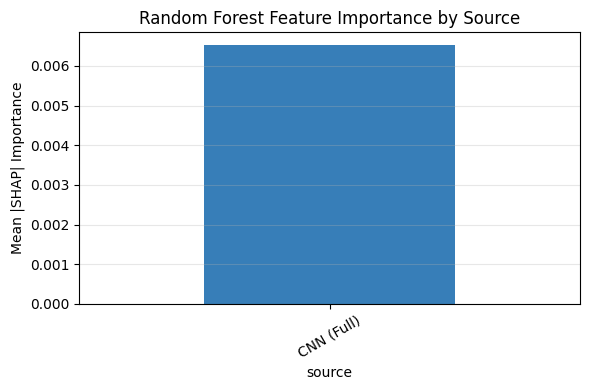

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
grouped_rf.plot(kind='bar', color=['#377eb8','#4daf4a','#984ea3','#ff7f00'])
plt.ylabel("Mean |SHAP| Importance")
plt.title("Random Forest Feature Importance by Source")
plt.xticks(rotation=30)
plt.grid(alpha=0.3, axis='y')
plt.tight_layout()
plt.show()


In [31]:
## UNEXPECTED RESULTS 
## Any way also to make it choose more often the BLR

# RF
predict_fn = gbm_model.predict_proba

# SHAP 
explainer_gbm = shap.Explainer(predict_fn, X_test, algorithm='permutation')
shap_values_gbm = explainer_gbm(X_test)

# Multi-class SHAP (n_samples, n_features, n_classes)
shap_vals = shap_values_gbm.values
if shap_vals.ndim == 3:
    mean_abs_shap_gbm = np.abs(shap_vals).mean(axis=(0, 2))
else:
    mean_abs_shap_gbm = np.abs(shap_vals).mean(axis=0)

# Align feature lengths 
n_features = min(len(feature_cols), len(mean_abs_shap_gbm))
feature_names = feature_cols[:n_features]
mean_abs_shap_gbm = mean_abs_shap_gbm[:n_features]

importance_df_gbm = pd.DataFrame({
    'feature': feature_names,
    'importance': mean_abs_shap_gbm})

# Assign labels
importance_df_gbm['source'] = importance_df_gbm['feature'].apply(
    lambda f: (
        'CNN (Full)' if 'cnn_full' in f else
        'CNN (Drop)' if 'cnn_drop' in f else
        'BLR (Full)' if 'blr_full' in f else
        'BLR (Drop)' if 'blr_drop' in f else 'Other'))

# Aggregate
grouped_gbm = importance_df_gbm.groupby('source')['importance'].mean().sort_values(ascending=False)
print("Gradient Boosting SHAP Feature Importance")
print(grouped_gbm)


PermutationExplainer explainer: 4801it [1:30:04,  1.13s/it]                          

Gradient Boosting SHAP Feature Importance
source
CNN (Full)    0.012169
Name: importance, dtype: float64


### Meta-Learner (Full & Dropout Images Predictions)

### Overall Performance Comparison — Full vs Degraded Images

| Metric Direction | **↑ Accuracy** | **↓ NLL** | **↓ ECE** |
|:-------------------|:--------------:|:----------:|:----------:|
| Bayesian (BLR, Full Images) | Test = 54.63% | Test = 0.8906 | Test = 0.0197 |
| Bayesian (BLR, Degraded Images) | Test = 57.37% | Test = 0.8715 | Test = 0.0290 |
| CNN (Calibrated, Full Images) | Test = 89.19% | Test = 0.3113 | Test = 0.0181 |
| CNN (Calibrated, Degraded Images) | Test = 89.19% | Test = 0.3113 | Test = 0.0181 |
| Logistic Regression (Meta-Learner) | Val = 89.71%, Test = 89.81% | Val = 0.3007, Test = 0.2988 | Val = 0.0065, Test = 0.0097 |
| Random Forest (Meta-Learner) | Val = 100.00%, Test = 90.29% | Val = 0.0687, Test = 0.3228 | Val = 0.0608, Test = 0.0264 |
| Gradient Boosting (Meta-Learner) | Val = 95.19%, Test = 89.60% | Val = 0.1474, Test = 0.2999 | Val = 0.0325, Test = 0.0235 |


- Logistic Regression provides the best generalization (lowest NLL & ECE on both val/test)
- Random Forest clearly overfits (100% Val Acc but drop on Test + higher NLL)
- Gradient Boosting performs well, slightly under LogReg, showing slight overfitting too 

Logistic Regression is the best for now (static) for the other nonlinear cases i should optimise them to improve generalisation
